# P12_1 Choice of algorithm

In this notebook we will check the performance of 4 machine learning algorithms:

- K-Nearest-Neighbor
- Random Forest
- Logistic Regression
- Extreme Gradient Boosting
- Explainable Boosting
- Gaussian Mixture Model

## Packages and data import

In [4]:
# Import packages
## Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import Image
import time

## Machine learning base functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.stats.stattools import durbin_watson ## Test of independence of residuals

## ML hyperparameter optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeltaYStopper ## Early stopper

## Fill missing values
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Algorithm efficiency tests
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

## Model export
import joblib

## other
import warnings
warnings.filterwarnings("ignore", message="The objective has been evaluated at point")


In [2]:
# Import files
notes_df = pd.read_csv( "../Data/billets.csv", sep = ';' )
pd.DataFrame.head( notes_df )

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

## Description of the data

In [8]:
print(f'We have data for {notes_df.shape[0]} notes.\n\n NA count:')

## Define function to apply
def countna(ser):
    val = ser.isna().sum()
    return val

## Count na per column
notes_df.apply(countna)

We have data for 1500 notes.

 NA count:


is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

We have NAs for 37 margin_low values, but the rest of the dataset is complete.

I plot the difference between fake and real notes on the different variables to see which ones are the most informative.

In [37]:
# Melt to long format
notes_long_df = pd.DataFrame.melt(notes_df, 
                                  id_vars=["is_genuine"], 
                                  value_vars=list(notes_df.columns[1:]))
pd.DataFrame.head(notes_long_df)

is_genuine  variable   value
0        True  diagonal  171.81
1        True  diagonal  171.46
2        True  diagonal  172.69
3        True  diagonal  171.36
4        True  diagonal  171.73

<Axes: xlabel='variable', ylabel='value'>

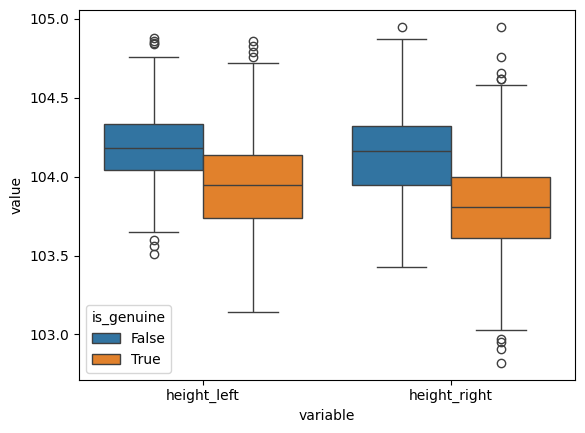

In [5]:
## Note height plot
sns.boxplot(data = notes_long_df[np.isin(notes_long_df['variable'],
                                     ['height_left', 'height_right'])],
            x = "variable", y = 'value',
            hue = 'is_genuine')

The fake notes tend to be slightly higher than the real ones on both sides.

<Axes: xlabel='variable', ylabel='value'>

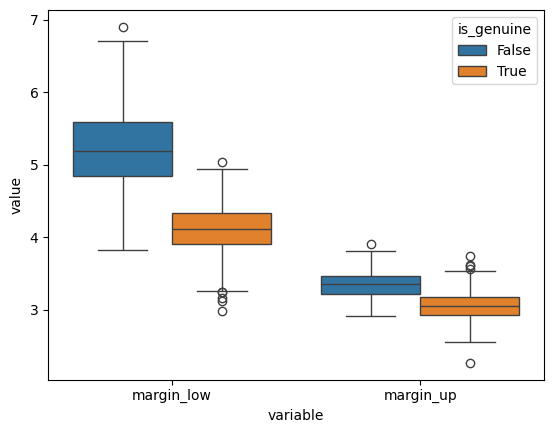

In [6]:
## Note margin plot
sns.boxplot(data = notes_long_df[np.isin(notes_long_df['variable'],
                                     ['margin_low', 'margin_up'])],
            x = "variable", y = 'value',
            hue = 'is_genuine')

The fake notes tend to have higher margins than the real ones.

<Axes: xlabel='variable', ylabel='value'>

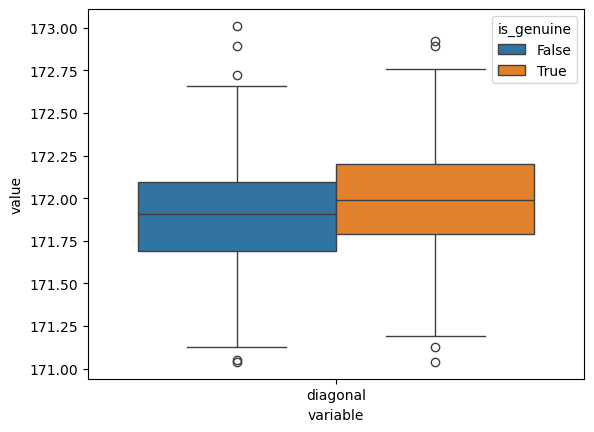

In [7]:
## Note diagonal plot
sns.boxplot(data = notes_long_df[np.isin(notes_long_df['variable'],
                                     ['diagonal'])],
            x = "variable", y = 'value',
            hue = 'is_genuine')

The diagonals of real and fake notes are similar.

<Axes: xlabel='variable', ylabel='value'>

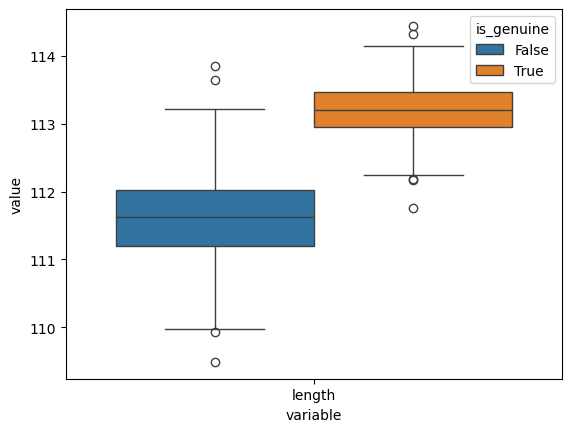

In [8]:
## Note length plot
sns.boxplot(data = notes_long_df[np.isin(notes_long_df['variable'],
                                     ['length'])],
            x = "variable", y = 'value',
            hue = 'is_genuine')

The fake notes are shorter than the real ones.

Based on all these observations, the differences between fake and real notes do not seem strong enough to differentiate them based soleley with one variable. However it could be possible if we associate the different variables. We will plot these variables two by two to see.

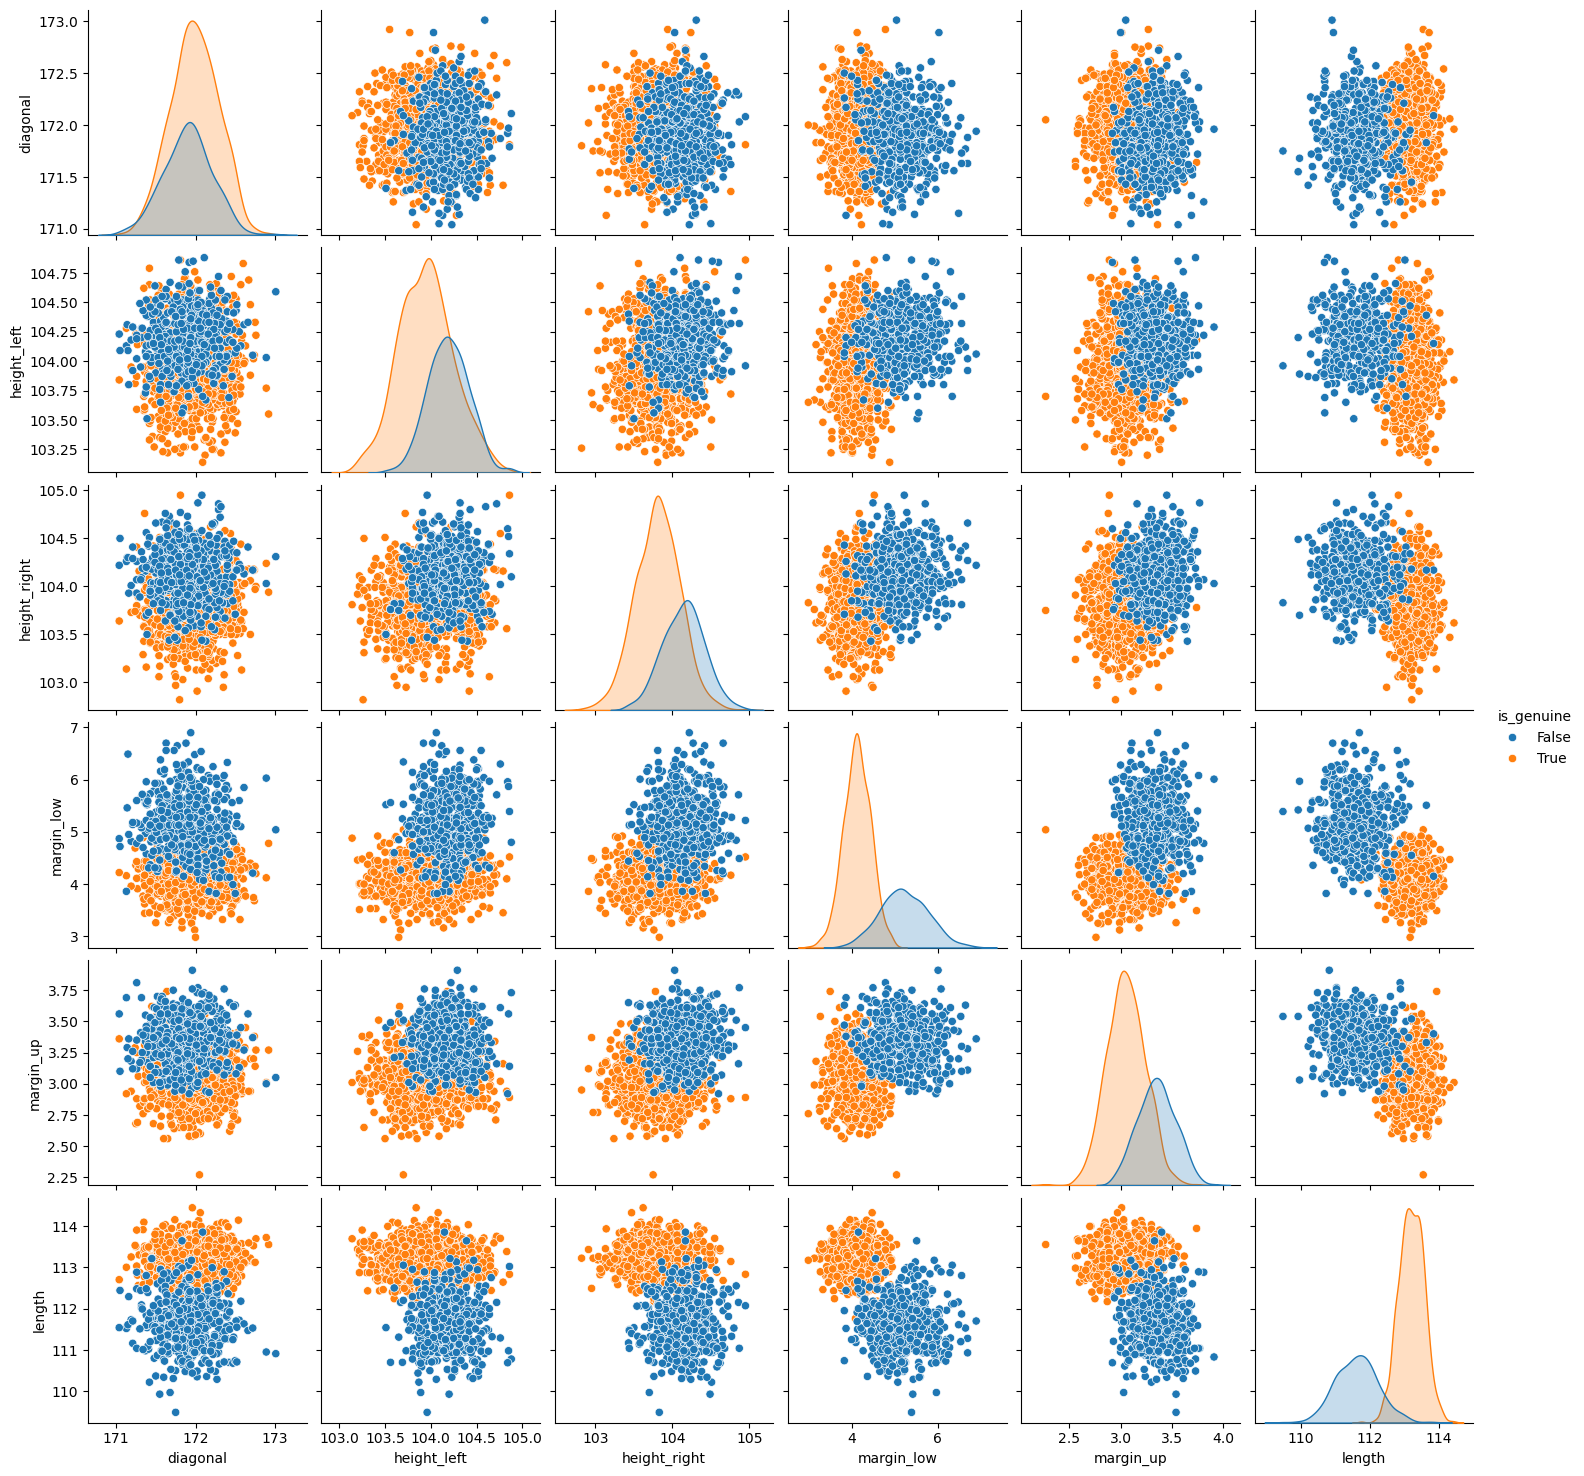

In [9]:
## pairplot
sns.pairplot(data = notes_df, 
             hue='is_genuine')

We see clearly two different groups, they are especially visible when we plot margin_low on length. Apart from the diagonal, all the variables seem informative.

# Filling missing values based on multiple linear regression
We need to fill the missing values for the margin_low column. To do so we will make a multiple linear regression.
To do so we will first remove the rows with missing values, then we will test the assumptions of the linear regression:

- there is a **linear relationship** between the independent and dependent variable
- The **residuals** are **independant**
- The **residuals** have a **constant variance** at every level of the independent variable.
- The **residuals** are **normally distributed**

After this we will choose the predictive variables and fit the model with them.

There is normally a last assumption, which is the absence of multicolinearity. This assumption is less important when we want to predict a value, so we will not test it here.

## Linear regression assumptions

The assumptions are based on the residuals of a linear simple relationship between each independent variable and the dependent variable. We will first fit the model before studying the variables

### Linearity
First of all we will check if there is a linear relationship between the margin_low and each other variable. To do so we will try to fit a simple linear model between each variable and margin_low and decide if the relationship is linear based on vizualisation and accuracy metrics.

We start with dividing the known data into training and testing sets.

In [6]:
## Drop rows with NaNs
notes_nona = notes_df.dropna( subset = ['margin_low'] )

## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( [ 'margin_low' ], axis = 1 )
y = notes_nona['margin_low']

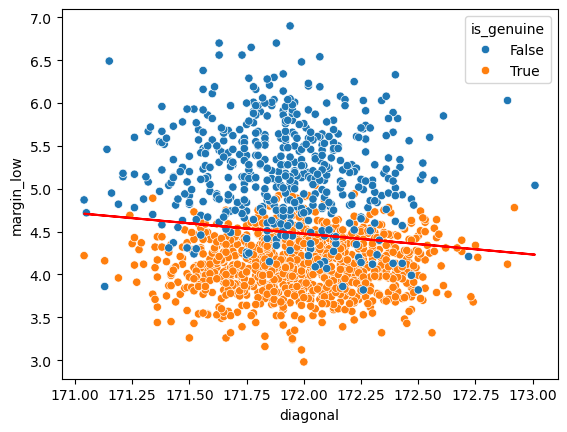

R-squared diagonal: 0.012439850430716826


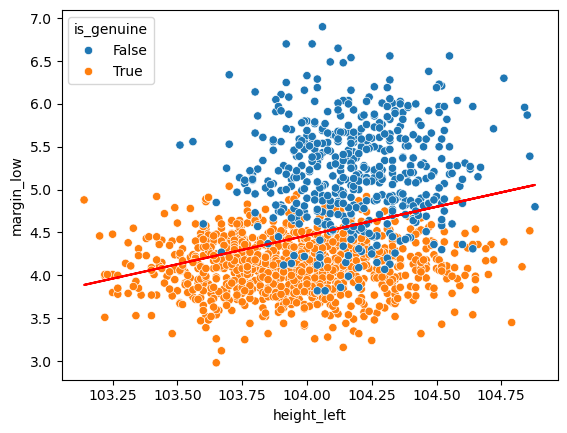

R-squared height_left: 0.09159276027592533


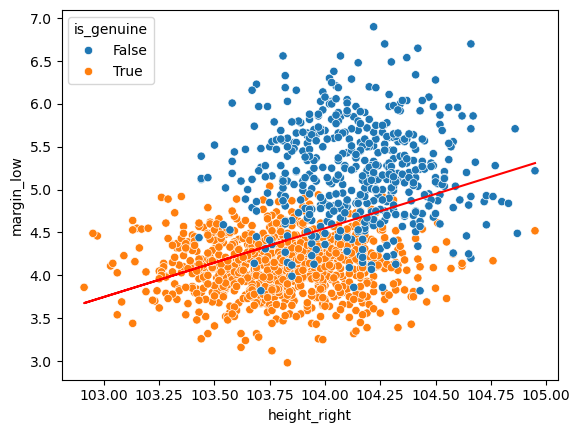

R-squared height_right: 0.15294759201240626


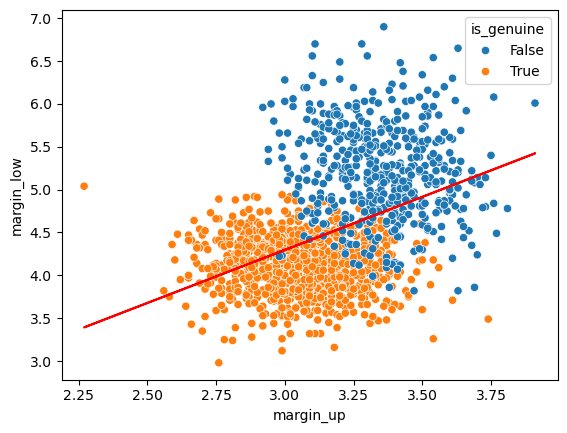

R-squared margin_up: 0.18628380252698062


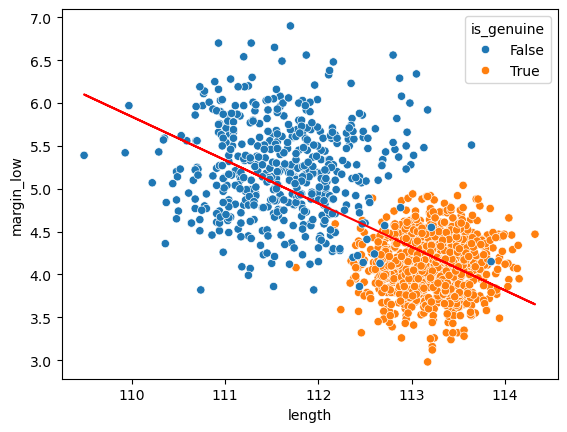

R-squared length: 0.4445592708293492


In [7]:
# Fit a simple linear regression model
def linear_mod(ser):
    ## Fit simple linear model
    linearmod = sm.add_constant( ser )
    fit_mod = sm.OLS(y, linearmod).fit()
    
    return fit_mod, linearmod


def plot_mod(ser, model, line):
    ## Plot model
    sns.scatterplot(x = ser,
                   y = y,
                   hue = notes_nona['is_genuine'])
    
    plt.plot(ser,
            model.predict(line),
            color = 'red')

    plt.show()

## Fit and plot the model for for each variable
model_diagonal, line_diagonal = linear_mod( X['diagonal'] )
plot_mod( X['diagonal'], model_diagonal, line_diagonal)
print(f'R-squared diagonal: {model_diagonal.rsquared}')

model_hleft, line_hleft = linear_mod(X['height_left'])
plot_mod( X['height_left'], model_hleft, line_hleft )
print(f'R-squared height_left: {model_hleft.rsquared}')

model_hright, line_hright = linear_mod(X['height_right'])
plot_mod( X['height_right'], model_hright, line_hright )
print(f'R-squared height_right: {model_hright.rsquared}')

model_mup, line_mup = linear_mod(X['margin_up'])
plot_mod( X['margin_up'], model_mup, line_mup)
print(f'R-squared margin_up: {model_mup.rsquared}')

model_length, line_length = linear_mod(X['length'])
plot_mod( X['length'], model_length, line_length)
print(f'R-squared length: {model_length.rsquared}')


Apart from the diagonal, we can imagine a vaguely linear relationship with the other variables.
It seems though that there is frequently an elbow in the relationship, we will see if adding a polynomial feature increases the accuracy.

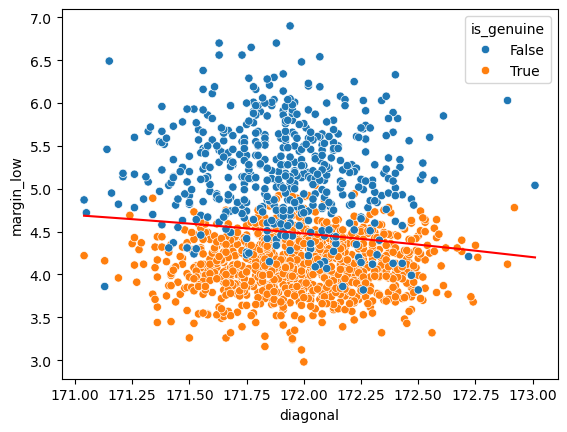

R-squared: 0.012475441729170256


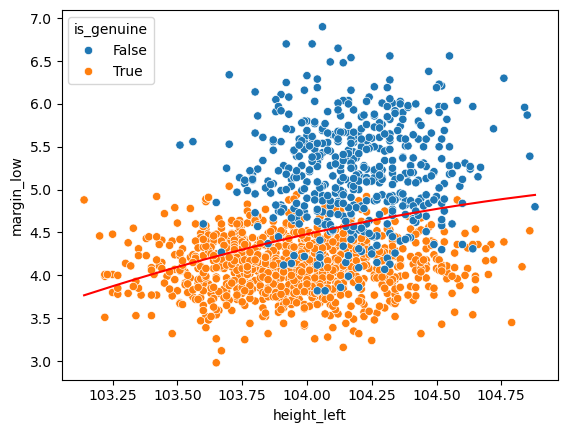

R-squared: 0.09263749334257365


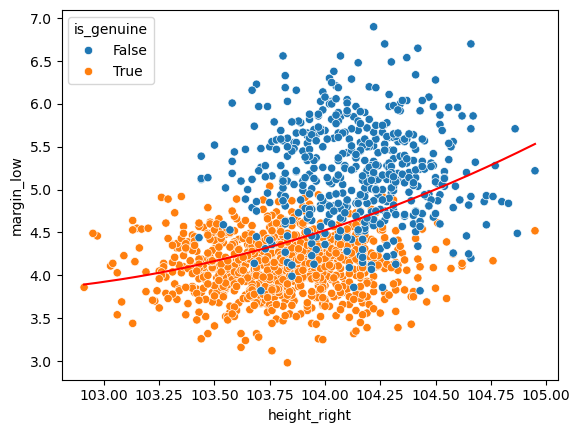

R-squared: 0.15564278473110504


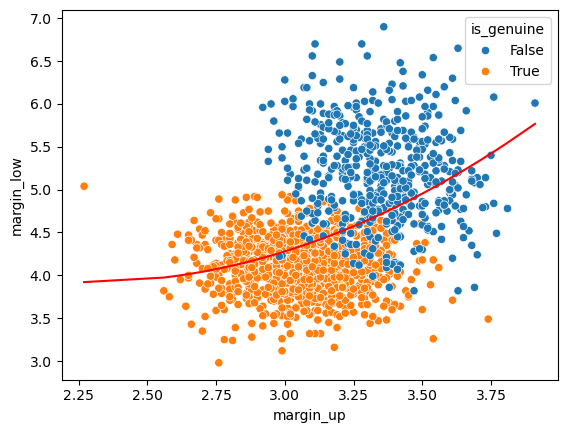

R-squared: 0.1916926723724094


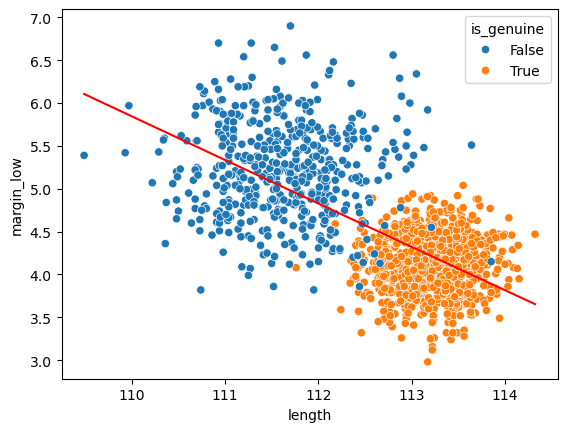

R-squared: 0.4445601675999823


In [8]:
# Define linear regression model
def linear_mod(ser):
    ser = ser.values.reshape( -1, 1)
    ## Add polynomial feature
    poly = PolynomialFeatures( degree = 2)
    x_poly = poly.fit_transform( ser )

    ## Fit the polynomial regression model
    model = LinearRegression().fit( x_poly, np.array(y) )
    
    ## Predict and plot
    y_pred = model.predict(x_poly)

    ## get R2 score
    r2 = model.score(x_poly, y)
    
    return y_pred, model, r2


def plot_mod(ser, line):
    ## Plot data
    sns.scatterplot(x = ser,
                   y = y,
                   hue = notes_nona['is_genuine'])

    # Sort the data points for clean line plotting
    sorted_indices = np.argsort(ser)
    ser_sorted = ser.values[sorted_indices]
    line_sorted = line[sorted_indices]

    ## Plot model results
    plt.plot(ser_sorted,
            line_sorted,
            color = 'red')

    plt.show()

## Fit and plot the model for for each variable
line, model, r2_sc = linear_mod( X['diagonal'] )
plot_mod( X['diagonal'], line)
print(f'R-squared: {r2_sc}')

line, model, r2_sc = linear_mod( X['height_left'] )
plot_mod( X['height_left'], line)
print(f'R-squared: {r2_sc}')

line, model, r2_sc = linear_mod( X['height_right'] )
plot_mod( X['height_right'], line)
print(f'R-squared: {r2_sc}')

line, model, r2_sc = linear_mod( X['margin_up'] )
plot_mod( X['margin_up'], line)
print(f'R-squared: {r2_sc}')

line, model, r2_sc = linear_mod( X['length'] )
plot_mod( X['length'], line)
print(f'R-squared: {r2_sc}')



The polynomial function does not change the accuracy much.
For the multiple linear regression, we will not keep any variable with a score below 0.1, we will then use the height_right, margin_up and length variables.

To test the rest of the assumptions, we will fit again the 

In [10]:
## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( ['is_genuine', 'margin_low', 'diagonal', 'height_left'], axis = 1 )
y = notes_nona['margin_low']

## Define function to get residuals
def get_resid(ser):
    ## Fit simple linear model
    linearmod = sm.add_constant( ser )
    fit_mod = sm.OLS(y, linearmod).fit()

    residuals = fit_mod.resid
    fit_vals = fit_mod.fittedvalues
    
    return residuals, fit_vals

## Get values
res_hright, val_hright = get_resid( X['height_right'] )
res_mup, val_mup = get_resid( X['margin_up'] )
res_length, val_length = get_resid( X['length'] )

### Independence of the residuals

We will test the independence of the residuals with the Durbin-Watson test.

In [11]:
print(f'Durbin-Watson statistic for the height_right: {durbin_watson(res_hright)}')

print(f'Durbin-Watson statistic for the margin_up: {durbin_watson(res_mup)}') 

print(f'Durbin-Watson statistic for the length: {durbin_watson(res_length)}') 

Durbin-Watson statistic for the height_right: 1.1683536161689074
Durbin-Watson statistic for the margin_up: 1.3208023764465688
Durbin-Watson statistic for the length: 1.86552539795226



The Durbin-Watson statistic indicates the autocorrelation of the data and is usually interpreted in the following way:

- DW statistic < 1.5, it indicates positive autocorrelation.
- 1.5 < DW statistic < 2.5, it suggests little to no autocorrelation.
- DW statistic > 2.5, it indicates negative autocorrelation.

For our variables, we see that the residuals of height_right and margin_up have a positive autocorrelation, which is a problem.

### Homoscedasticity of the residuals
We check if the variance of the residuals remain constant across the fitted values.

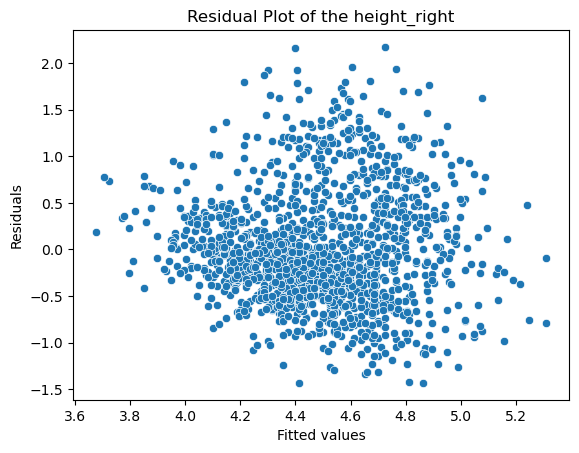

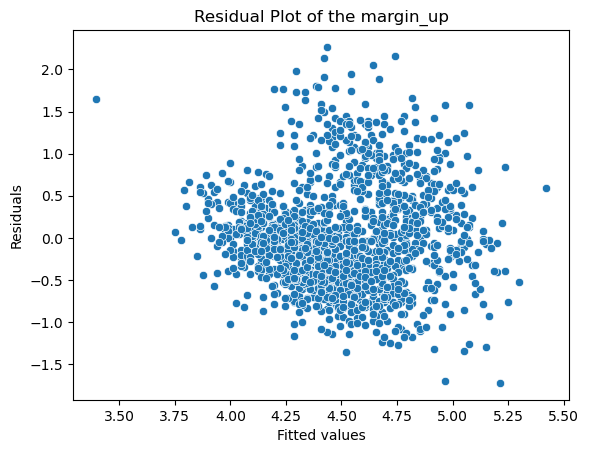

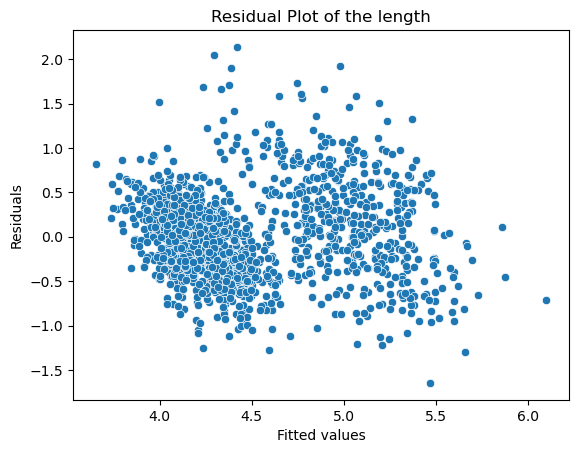

In [12]:
# Define plot
def resid_plot(x, y, title):
    sns.scatterplot(x = x, y = y)
    plt.xlabel( 'Fitted values' )
    plt.ylabel( 'Residuals' )
    plt.title( 'Residual Plot of the ' + title )
    plt.show()

resid_plot( val_hright, res_hright, 'height_right')
resid_plot( val_mup, res_mup, 'margin_up')
resid_plot( val_length, res_length, 'length')

The variance of the residuals is not homogeneous for any of the variables.

### Normality of the residuals
We will now check the normality of the distribution of the residuals:

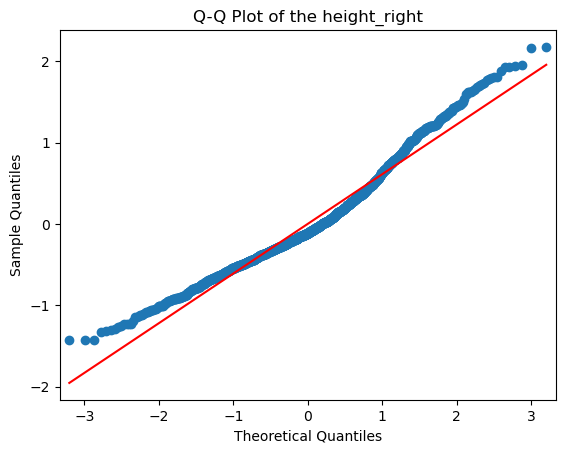

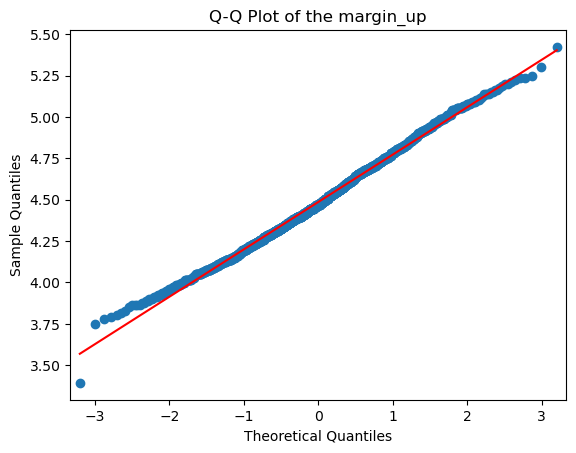

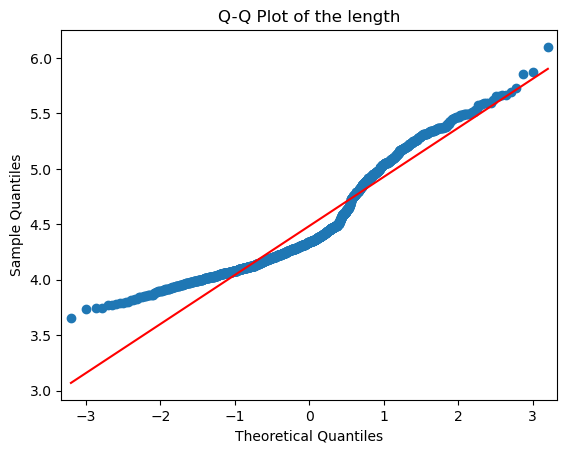

In [13]:
# Normality (Q-Q plot)
def resid_qq(x, title):
    sm.qqplot(x, line='s')
    plt.title('Q-Q Plot of the ' + title)
    plt.show()

resid_qq( res_hright, 'height_right')
resid_qq( val_mup, 'margin_up')
resid_qq( val_length, 'length')


The residuals of height_right and margin_up are normally distributed, but the residuals of the length are not.

### Run multiple linear regression

In [14]:

## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( ['is_genuine', 'margin_low', 'diagonal', 'height_left'], axis = 1 )
y = notes_nona['margin_low']

# Split training and testing set 80:20
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

# Fit the model
model = LinearRegression()
model.fit(x_train, y_train)

# Predict on the train and test sets
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# Calculate R²
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f'R² for the train set: {r2_train}')
print(f'R² for the test set: {r2_test}')

# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Mean Squared Error for the train set: {mse_train}')
print(f'Mean Squared Error for the test set: {mse_test}')

R² for the train set: 0.47397370384535564
R² for the test set: 0.44256708396896804
Mean Squared Error for the train set: 0.23382326548068416
Mean Squared Error for the test set: 0.23448298053841238


The model is not overfit, but the R-squared is below 0.5, which is not great. We could go with this one but we will try a Random Forest Regressor to see if we get better results

## Predict missing values with a Random Forest
### Make basic RandomForest

In [59]:
## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( [ 'margin_low' ], axis = 1 )
y = notes_nona['margin_low']

## Split training and testing set 80:20
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 68)

## Create model
rf = RandomForestRegressor( random_state = 68)

## Fit model
rf.fit(x_train, y_train)

## get R2 for the train and test sets
print("R² score on training set:", rf.score(x_train, y_train))
print("R² score on validation set:", rf.score(x_test, y_test))


R² score on training set: 0.9409136141495205
R² score on validation set: 0.5598161222165476


The precision on the training set is much higher than in the validation set. This shows that the model is badly overfitted with the basic parameters. Despite being overfitted, the R-squared is 10% better with the multiple linear regression.

### Find best hyperparameters with Bayesian Search

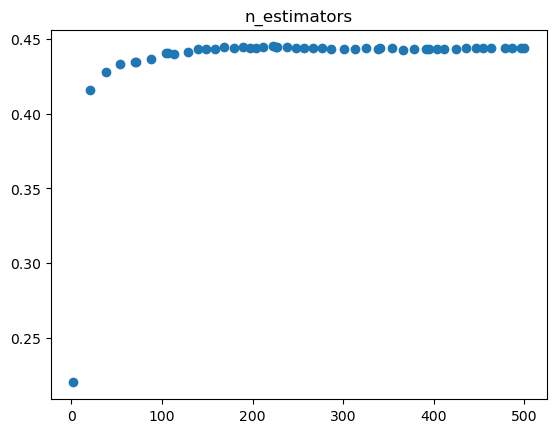

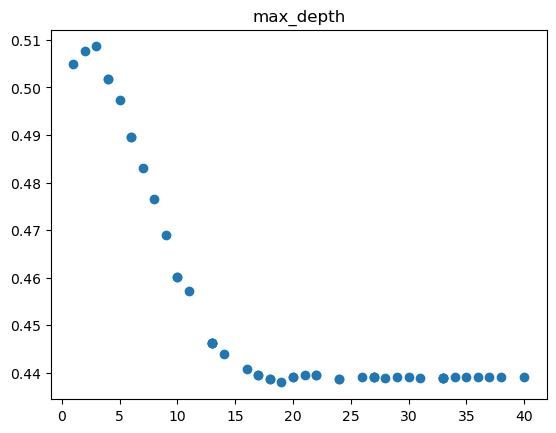

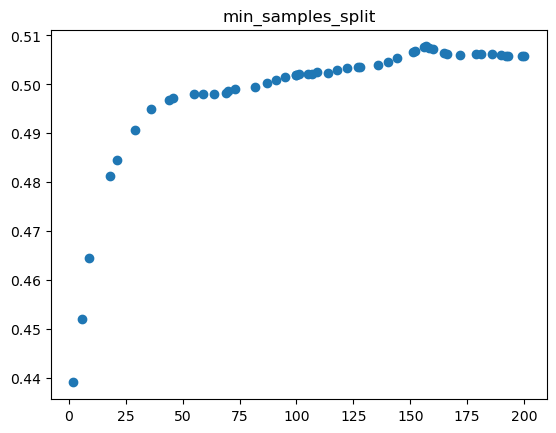

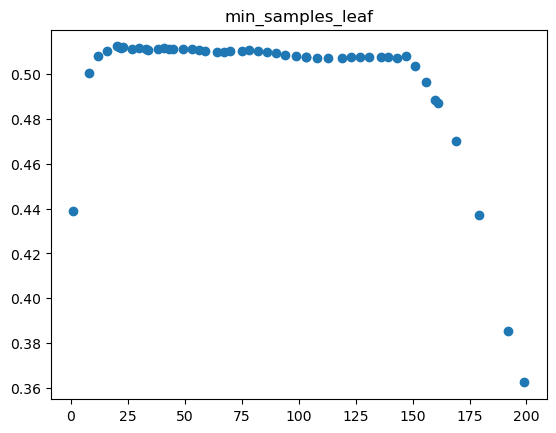

In [15]:
## Define function to explore each parameter separately
def bayes_single_search(model, X, y, sp):
    # Early stopping if R² doesn't improve by at least 0.002 for 10 rounds
    early_stop = DeltaYStopper( delta = 0.001 )
    all_plots = {}

    for n in search_spaces.keys():
        sp = { n : search_spaces[n] }
        # Set up Bayesian hyperparameter search
        opt = BayesSearchCV(
            estimator = model,
            search_spaces = sp,
            n_iter = 50,
            scoring = 'r2',
            cv = 3,
            n_jobs = -1,
            verbose = 0,
            random_state = 68,
            refit = True
            )
        
        # Fit the model with early stopping
        opt.fit(X, y)

        ## Create 
        temp_df = pd.DataFrame( { n : opt.cv_results_['param_' + n].compressed(),
                                 'mean_R_sq' : opt.cv_results_['mean_test_score']} )

        ## Create lineplot and 
        temp_plot, ax = plt.subplots()
        ax.scatter( temp_df[n], temp_df['mean_R_sq'] )
        ax.set_title( n )

        all_plots[n] = temp_plot

    return all_plots

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)

## Define the model
model = RandomForestRegressor(random_state = 68)

## Define the hyperparameter search space
search_spaces = {
    'n_estimators': Integer( 2, 500 ),
    'max_depth': Integer(1, 40),
    'min_samples_split': Integer(2, 200),
    'min_samples_leaf': Integer(1, 200)
}

## Run the function
all_plots = bayes_single_search(model = model,
                                X = x_train, y = y_train,
                                sp = search_spaces)

### Fine tuning bayesian search
We will use the best ranges above to find the best hyperparameter with a Bayesian search, this time on all hyperparameters at once.

In [5]:
## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( [ 'margin_low' ], axis = 1 )
y = notes_nona['margin_low']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)

## Define the model
model = RandomForestRegressor(random_state = 68)

## Set early stop
early_stop = DeltaYStopper( delta = 0.001 , n_best = 10)

## Define search space based on previous plots
search_spaces = {
    'n_estimators': Integer( 100, 300 ),
    'max_depth': Integer(2, 5),
    'min_samples_split': Integer(100, 160),
    'min_samples_leaf': Integer(10, 150)
}


## Bayesian search parameters
opt = BayesSearchCV(
    estimator = model,
    search_spaces = search_spaces,
    n_iter = 100,
    scoring = 'r2',
    cv = 5,
    n_jobs = - 1,
    verbose = 0,
    random_state = 68,
    refit = True
)

## Fit model without early stop
opt.fit(x_train, y_train, callback = [early_stop])

print("Best Parameters:", opt.best_params_)
print("Best R² score (CV):", opt.best_score_)

Best Parameters: OrderedDict({'max_depth': 2, 'min_samples_leaf': 81, 'min_samples_split': 100, 'n_estimators': 100})
Best R² score (CV): 0.6068480032200252


In [6]:
## Create X and y arrays with dependent and independent variables
X = notes_nona.drop( [ 'margin_low' ], axis = 1 )
y = notes_nona['margin_low']

## Split the data between training and testing datasets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, 
                                                  random_state = 68 )

## Define the model
model = RandomForestRegressor( **opt.best_params_ ,  random_state = 68 )

model.fit(X_train, y_train)


## Check the R2 metrics
print("R² score on training set:", model.score(X_train, y_train))
print("R² score on validation set:", model.score(X_test, y_test))

R² score on training set: 0.6214477438150854
R² score on validation set: 0.6192793391721135


With the best hyperparameters, we an R-squared of 0.62 with no overfitting.
It is much better than the MLR above, which had a R-squared of 0.46.

### Fill missing values

Let's fill the missing values based on this model and move on the the categorization.

In [9]:
## Get only rows with NA
notes_na = notes_df[notes_df['margin_low'].isnull()]

## Get index of rows with NAs
index_na = notes_na.index

## Get only predictors
x_pred = notes_na.drop('margin_low', axis = 1)

## Predict missing values
predicted_vals = model.predict(x_pred).round(2)

## Replace missing values
notes_full = notes_df.reset_index(drop = True)
notes_full.iloc[index_na, notes_full.columns == 'margin_low'] = predicted_vals
display( notes_full.iloc[index_na, :].head())

## Count na per column
print('\nNumber of NAs per column:')
notes_full.apply(countna)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72         True    171.94       103.89        103.45        4.10       3.25   
99         True    171.93       104.07        104.18        4.11       3.14   
151        True    172.07       103.80        104.38        4.13       3.02   
197        True    171.45       103.66        103.80        4.09       3.62   
241        True    171.83       104.14        104.06        4.12       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36


Number of NAs per column:


is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [11]:
## Save as a new csv file
notes_full.to_csv('../Data/notes_data_full.csv', index = False)

# Run Various algorithms
We will try 4 algorithm and assess their precision and execution times.
We will use the f1 metric to optimize their accuracy. This metric promotes equally low false positive and low false negative rates. 
This metric could be changed with the recall or precision metric, which would focus on reducing either the false negative or false positive rate.

In [2]:
## Import full data
notes_full = pd.read_csv('../Data/notes_data_full.csv')

In [11]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Define function to explore each parameter separately (same as above)
def bayes_single_search(model, X, y, sp, njobs = -1):
    # Early stopping if R² doesn't improve by at least 0.002 for 10 rounds
    early_stop = DeltaYStopper( delta = 0.001, n_best = 10 )
    all_plots = {}

    for n in sp.keys():
        search_p = { n : sp[n] }
        # Set up Bayesian hyperparameter search
        opt = BayesSearchCV(
            estimator = model,
            search_spaces = search_p,
            n_iter = 50,
            scoring = 'f1', ## Used to reduce both false positive and false negative
            cv = 3,
            n_jobs = njobs,
            verbose = 0,
            random_state = 68,
            refit = True
            )
        
        # Fit the model with early stopping
        opt.fit( X, y, callback = [early_stop])

        ## Create 
        temp_df = pd.DataFrame( { n : opt.cv_results_[ 'param_' + n ].compressed(),
                                 'mean_f1' : opt.cv_results_[ 'mean_test_score' ]} )

        ## Create scatterplot
        temp_plot, ax = plt.subplots()
        ax.scatter( temp_df[n], temp_df['mean_f1'] )
        ax.set_title( n )

        all_plots[n] = temp_plot

    return all_plots

def confusion_matrix_plot( actual, pred ):
    cm = confusion_matrix( actual, pred )
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## K-Nearest Neighbors
We want to chose the right number of neighbors, we will then iterate the knn fitness test over increasing numbers of neighbors up to 15. The we will plot the error rate of each number of neighbors and chose this parameter accordingly. We will only keep the error and time values with the set amount of neighbors for comparison with the other models.

### Find best hyperparameters
Like for filling the NAs, we will find the hyperparameters with a bayesian research on single parameters before going for all of them.

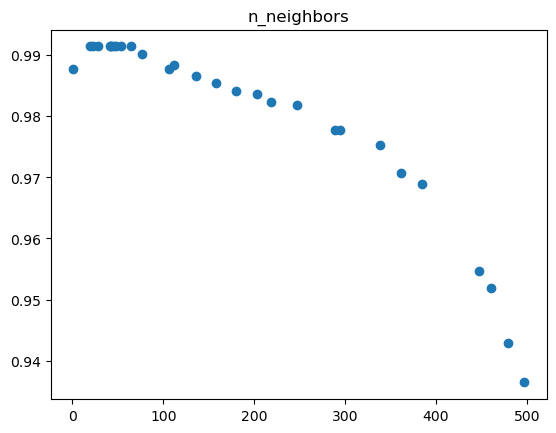

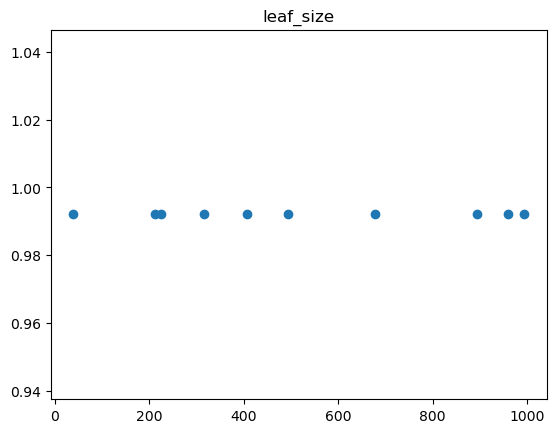

In [19]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
knn = neighbors.KNeighborsClassifier()

## Define the hyperparameter search space
search_spaces = {
    'n_neighbors': Integer( 1, 500 ),
    'leaf_size': Integer( 2, 1000 )
}

## Run the function
all_plots = bayes_single_search( model = knn,
                                X = x_train, y = y_train,
                                sp = search_spaces )

### Optimize hyperparameters

Based on these graphs, we select the following restrained search space:

In [13]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
knn = neighbors.KNeighborsClassifier()

## Define the hyperparameter search space
search_spaces = {
    'n_neighbors': Integer( 10, 50 ),
    'weights': Categorical( ['uniform', 'distance'] ),
    'algorithm': Categorical( ['ball_tree', 'kd_tree', 'brute'] ),
    'leaf_size': Integer( 2, 100 ),
    'p' : Integer( 1, 2 )
}

## Set early stop
early_stop = DeltaYStopper( delta = 0.001, 
                           n_best = 10 )

## Bayesian search parameters
opt_knn = BayesSearchCV(
    estimator = knn,
    search_spaces = search_spaces,
    n_iter = 70,
    scoring = 'f1',
    cv = 5,
    n_jobs = - 1,
    verbose = 0,
    random_state = 68,
    refit = True
)

## Fit model without early stop
opt_knn.fit( x_train, y_train, callback = [early_stop] )

# Predict on the test set
y_pred = opt_knn.predict( x_test )

print( "Best Parameters:", opt_knn.best_params_ )
print( "Best f1 score (CV):", opt_knn.best_score_ )

Best Parameters: OrderedDict({'algorithm': 'kd_tree', 'leaf_size': 11, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'})
Best f1 score (CV): 0.9932719306908926


The best f1 score is excellent.

We will check the false positive and false negative rates, as well as assessing the time it takes to train the model and predict the values.

### Evaluate model accuracy metrics and fitness

F1 score on training set: 0.9926289926289926
F1 score on validation set: 0.9947368421052631
Precision: 0.995
Recall:    0.995
Model fitness time: 0.0100
Model prediction time: 0.0300


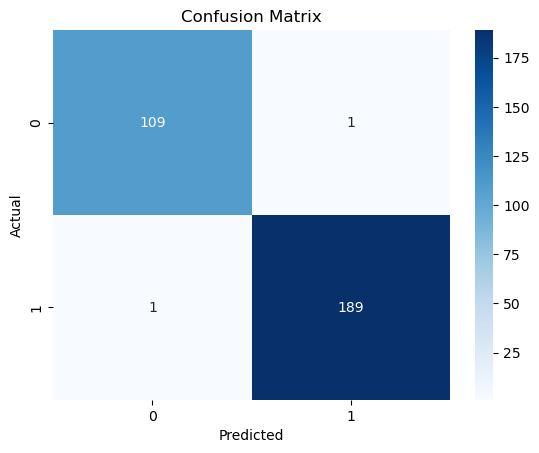

In [14]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
model = neighbors.KNeighborsClassifier( **opt_knn.best_params_ )

## Get time before fitness
start_fit = time.time()

## Fit model
model.fit(x_train, y_train)

## Get time after model fitness
end_fit = time.time()

## predict values for test set
y_test_pred = model.predict( x_test )

## Get prediction time
end_pred = time.time()

## predict values for train set
y_train_pred = model.predict( x_train )

## Check the F1 metrics for train and test sets
f1_knn = f1_score(y_test, y_test_pred)
print("F1 score on training set:", f1_score( y_train, y_train_pred))
print("F1 score on validation set:", f1_knn)

# Evaluate precision and recall values
precision_knn = precision_score( y_test, y_test_pred )
recall_knn = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_knn:.3f}" )
print( f"Recall:    {recall_knn:.3f}" )

## Get and show timings for fitness and prediction
time_fit_knn = (end_fit - start_fit)
time_pred_knn = (end_pred - end_fit)
print(f"Model fitness time: {time_fit_knn:.4f}")
print(f"Model prediction time: {time_pred_knn:.4f}")

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on training and validation sets are both excellent, there is no overfitting.

This model had no false positive and wrongly detected 1% of false negative. This looks low but is quite high in reality for a bank.

The model fitness and prediction time are almost instant.

## Random Forest Classifier

### Find best hyperparameters
Like for filling the NAs, we will find the hyperparameters with a bayesian research on single parameters before going for all of them.

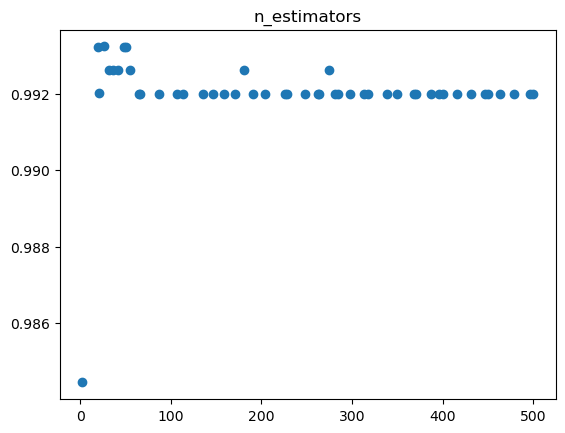

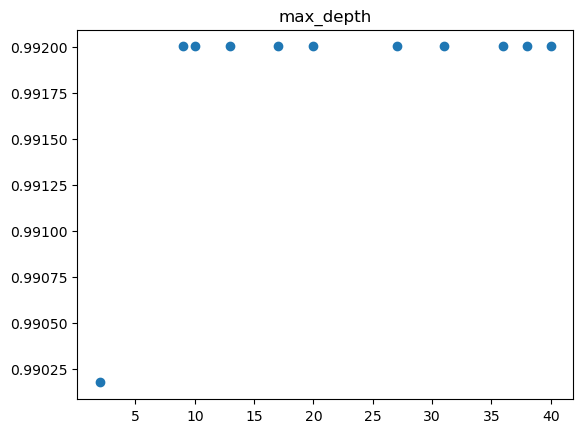

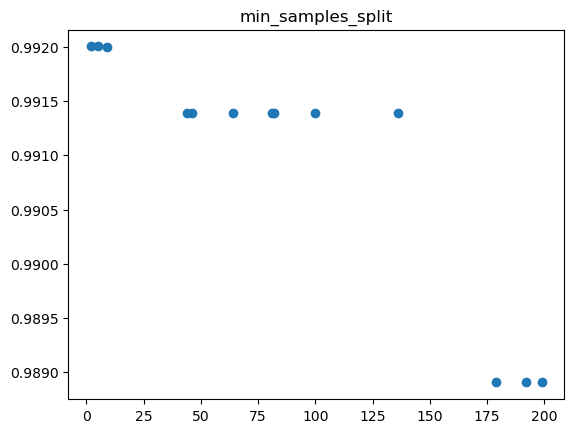

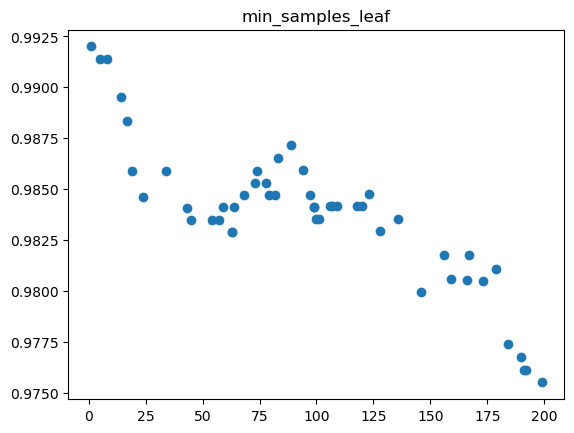

In [85]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
rfc = RandomForestClassifier( random_state = 68 )

## Define the hyperparameter search space
search_spaces = {
    'n_estimators': Integer( 2, 500 ),
    'max_depth': Integer( 1, 40 ),
    'min_samples_split': Integer( 2, 200 ),
    'min_samples_leaf': Integer( 1, 200 )
}

## Run the function
all_plots = bayes_single_search( model = rfc,
                                X = x_train, y = y_train,
                                sp = search_spaces )

### Optimize hyperparameters

Based on these graphs, we select the following restrained search space:

In [31]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
rfc = RandomForestClassifier( random_state = 68 )

## Define the hyperparameter search space
search_spaces = {
    'n_estimators': Integer( 10, 50 ),
    'max_depth': Integer( 7, 15 ),
    'min_samples_split': Integer( 2, 20 ),
    'min_samples_leaf': Integer( 1, 10 )
}

## Set early stop
early_stop = DeltaYStopper( delta = 0.001, 
                           n_best = 10 )

## Bayesian search parameters
opt_rfc = BayesSearchCV(
    estimator = rfc,
    search_spaces = search_spaces,
    n_iter = 70,
    scoring = 'f1',
    cv = 5,
    n_jobs = - 1,
    verbose = 0,
    random_state = 68,
    refit = True
)

## Fit model without early stop
opt_rfc.fit( x_train, y_train, callback = [early_stop] )

# Predict on the test set
y_pred = opt_rfc.predict( x_test )

print( "Best Parameters:", opt_rfc.best_params_ )
print( "Best f1 score (CV):", opt_rfc.best_score_ )

Best Parameters: OrderedDict({'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 48})
Best f1 score (CV): 0.9938724199784602


The best f1 score is excellent.

We will check the false positive and false negative rates, as well as assessing the time it takes to train the model and predict the values.

### Evaluate model accuracy metrics and fitness

F1 score on training set: 0.9981492905613819
F1 score on validation set: 0.9947643979057592
Precision: 0.990
Recall:    1.000
Model fitness time: 0.2539
Model prediction time: 0.0156


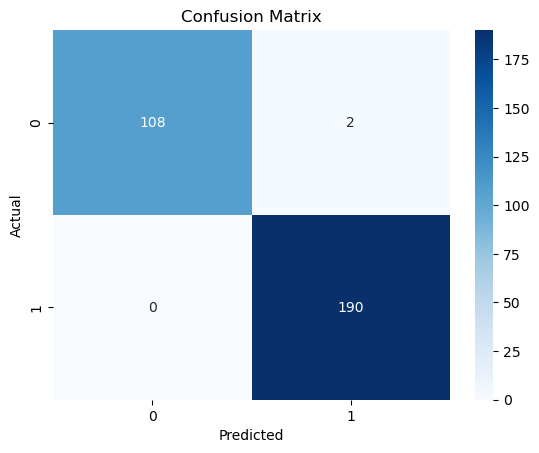

In [97]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
model = RandomForestClassifier( **opt_rfc.best_params_, random_state = 68 )

## Get time before fitness
start_fit = time.time()

## Fit model
model.fit(x_train, y_train)

## Get time after model fitness
end_fit = time.time()

## predict values for test set
y_test_pred = model.predict( x_test )

## Get prediction time
end_pred = time.time()

## predict values for train set
y_train_pred = model.predict( x_train )

## Check the F1 metrics for train and test sets
f1_rfc = f1_score(y_test, y_test_pred)
print("F1 score on training set:", f1_score( y_train, y_train_pred))
print("F1 score on validation set:", f1_rfc)

# Evaluate precision and recall values
precision_rfc = precision_score( y_test, y_test_pred )
recall_rfc = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_rfc:.3f}" )
print( f"Recall:    {recall_rfc:.3f}" )

## Get and show timings for fitness and prediction
time_fit_rfc = (end_fit - start_fit)
time_pred_rfc = (end_pred - end_fit)
print(f"Model fitness time: {time_fit_rfc:.4f}")
print(f"Model prediction time: {time_pred_rfc:.4f}")

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on training and validation sets are both excellent, there is no overfitting.

This model had no false positive and wrongly detected 1% of false negative. This looks low but is quite high in reality for a bank. It is exactly as good as the KNN algorithm.

The model fitness took 0.13 seconds and prediction time is almost instant.

## Logistic regression
We will follow the same process with a logistic regression

### Find best hyperparameters
Like for filling the NAs, we will find the hyperparameters with a bayesian research on single parameters before going for all of them.

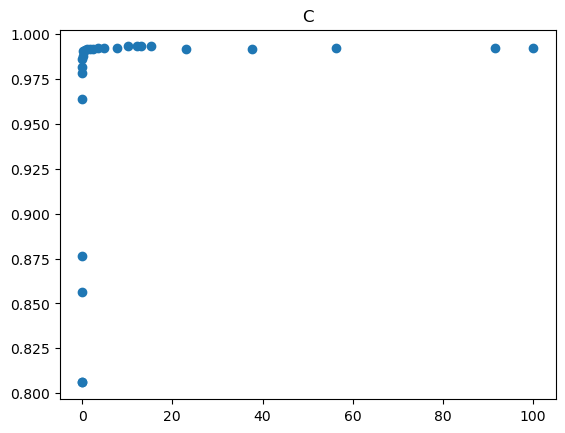

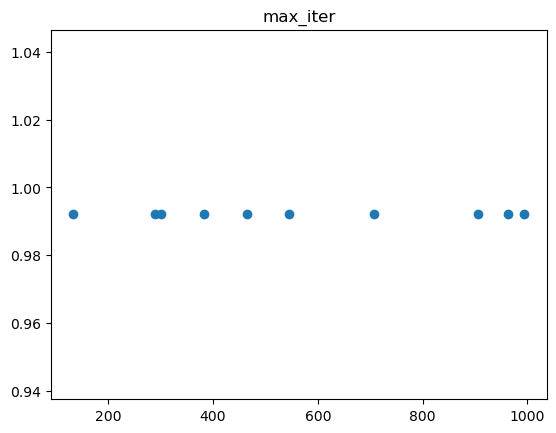

In [95]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
lgr = LogisticRegression( random_state = 68 )

## Define the hyperparameter search space
search_spaces = {
    'C': Real(1e-4, 1e2, prior='log-uniform'),
    'max_iter': Integer(100, 1000)
}

## Run the function
all_plots = bayes_single_search( model = lgr,
                                X = x_train, y = y_train,
                                sp = search_spaces )

### Optimize hyperparameters

Based on these graphs, we select the following restrained search space:

In [100]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
lgr = LogisticRegression( random_state = 68 )

## Define the hyperparameter search space
search_space = {
    'C': Real(5, 20, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear', 'saga']),
    'max_iter': Integer(100, 1000)
}

## Set early stop
early_stop = DeltaYStopper( delta = 0.001, 
                           n_best = 10 )

## Bayesian search parameters
opt_lgr = BayesSearchCV(
    estimator = lgr,
    search_spaces = search_space,
    n_iter = 70,
    scoring = 'f1',
    cv = 5,
    n_jobs = - 1,
    verbose = 0,
    random_state = 68,
    refit = True
)

## Fit model without early stop
opt_lgr.fit( x_train, y_train, 
            callback = [early_stop] )

# Predict on the test set
y_pred = opt_lgr.predict( x_test )

print( "Best Parameters:", opt_lgr.best_params_ )
print( "Best f1 score (CV):", opt_lgr.best_score_ )

Best Parameters: OrderedDict({'C': 6.803057058930984, 'max_iter': 173, 'penalty': 'l1', 'solver': 'liblinear'})
Best f1 score (CV): 0.9932569774219658


C:\Users\Vivien\anaconda3\envs\dython_env\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



The best f1 score is excellent.

We will check the false positive and false negative rates, as well as assessing the time it takes to train the model and predict the values.

### Evaluate model accuracy metrics and fitness

C:\Users\Vivien\anaconda3\envs\dython_env\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



F1 score on training set: 0.992619926199262
F1 score on validation set: 0.9947643979057592
Precision: 0.990
Recall:    1.000
Model fitness time: 0.6704
Model prediction time: 0.0000


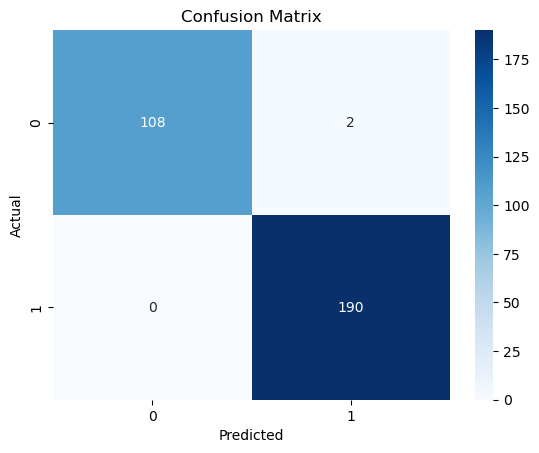

In [101]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop( ['is_genuine'], axis = 1 )
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, 
                                                  random_state = 68 )
## Define algorithm
model = LogisticRegression( **opt_lgr.best_params_, random_state = 68 )

## Get time before fitness
start_fit = time.time()

## Fit model
model.fit( x_train, y_train )

## Get time after model fitness
end_fit = time.time()

## predict values for test set
y_test_pred = model.predict( x_test )

## Get prediction time
end_pred = time.time()

## predict values for train set
y_train_pred = model.predict( x_train )

## Check the F1 metrics for train and test sets
f1_lgr = f1_score(y_test, y_test_pred)
print( "F1 score on training set:", f1_score( y_train, y_train_pred) )
print( "F1 score on validation set:",  f1_lgr)

# Evaluate precision and recall values
precision_lgr = precision_score( y_test, y_test_pred )
recall_lgr = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_lgr:.3f}" )
print( f"Recall:    {recall_lgr:.3f}" )

## Get and show timings for fitness and prediction
time_fit_lgr = (end_fit - start_fit)
time_pred_lgr = (end_pred - end_fit)
print( f"Model fitness time: {time_fit_lgr:.4f}" )
print( f"Model prediction time: {time_pred_lgr:.4f}" )

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on training and validation sets are both excellent, there is no overfitting.

This model has 0.5% of false negative and 0.5% of false positive. It is more balanced than the KNN and Random Forest.

The model fitness took 0.15 seconds and prediction time is almost instant.

## XGBoost
We will follow the same process with the XGBoost algorithm.

### Find best hyperparameters
Like for filling the NAs, we will find the hyperparameters with a bayesian research on single parameters before going for all of them.

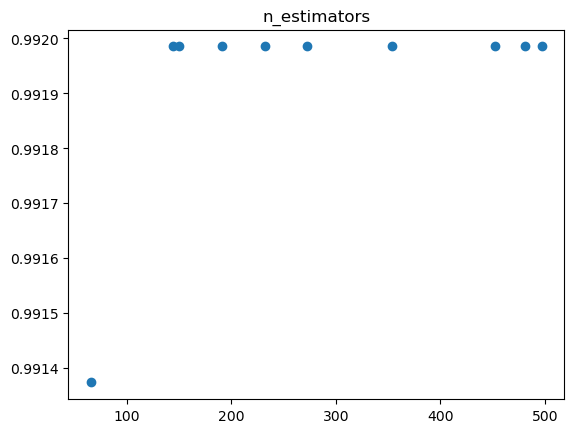

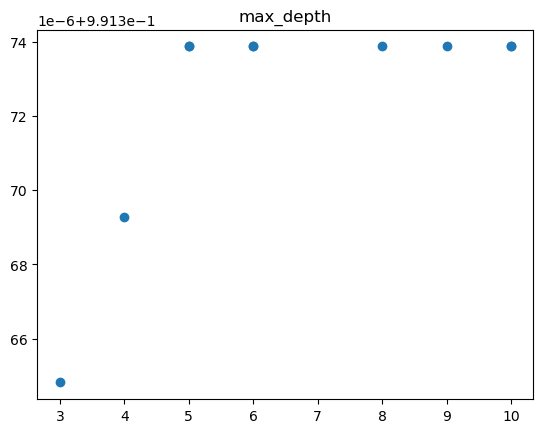

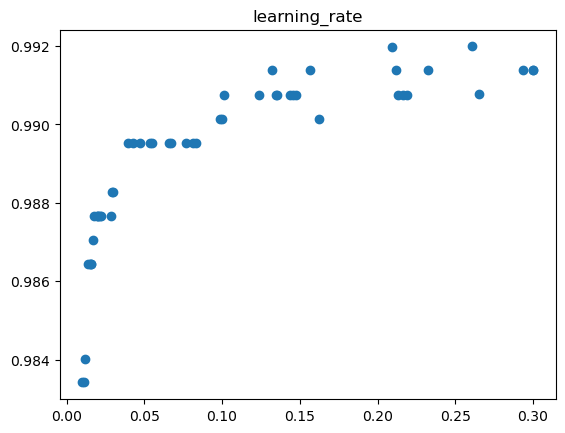

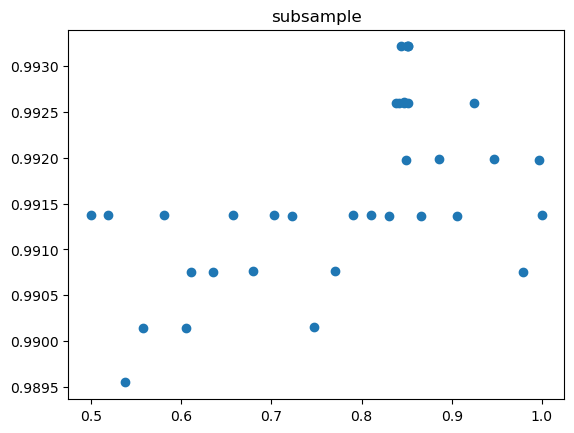

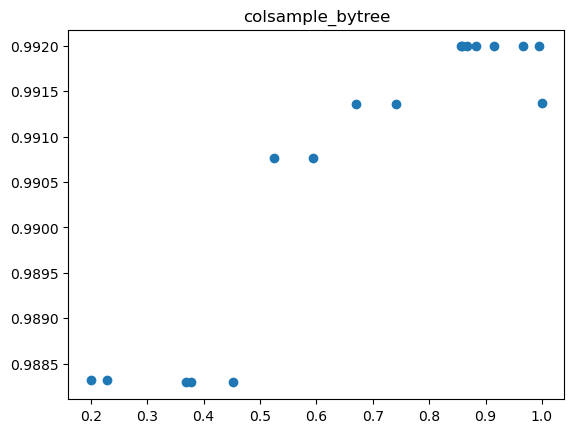

In [6]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)

## Define algorithm
ebm = XGBClassifier( objective = 'binary:logistic', random_state = 68 )

## Define the hyperparameter search space
search_space = {
    'n_estimators' : Integer( 50, 500), ## Number of trees
    'max_depth': Integer(3, 10), ## Depth of the tree
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0), ##the fraction of observations to be sampled for each tree
    'colsample_bytree': Real(0.2, 1.0) ## Fraction of columns randomly sampled by tree
}

## Run the function
all_plots = bayes_single_search( model = xgb,
                                X = x_train, y = y_train,
                                sp = search_space)

### Optimize hyperparameters

Based on these graphs, we select the following restrained search space:

In [104]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)
## Define algorithm
xgb = XGBClassifier( objective = 'binary:logistic', random_state = 68 )

## Define the hyperparameter search space
search_space = {
    'n_estimators' : Integer( 150, 300), ## Number of trees
    'max_depth': Integer(5, 8), ## Depth of the tree
    'learning_rate': Real(0.2, 0.3, prior='log-uniform'),
    'subsample': Real(0.8, 1.0), ##the fraction of observations to be sampled for each tree
    'colsample_bytree': Real(0.85, 1.0) ## Fraction of columns randomly sampled by tree
}

## Set early stop
early_stop = DeltaYStopper( delta = 0.001, 
                           n_best = 10 )

## Bayesian search parameters
opt_xgb = BayesSearchCV(
    estimator = xgb,
    search_spaces = search_space,
    n_iter = 70,
    scoring = 'f1',
    cv = 5,
    n_jobs = - 1,
    verbose = 0,
    random_state = 68,
    refit = True
)

## Fit model without early stop
opt_xgb.fit( x_train, y_train, 
            callback = [early_stop] )

# Predict on the test set
y_pred = opt_xgb.predict( x_test )

print( "Best Parameters:", opt_xgb.best_params_ )
print( "Best f1 score (CV):", opt_xgb.best_score_ )

Best Parameters: OrderedDict({'colsample_bytree': 0.9961679765505612, 'learning_rate': 0.20278648746115724, 'max_depth': 7, 'n_estimators': 156, 'subsample': 0.8291126900255071})
Best f1 score (CV): 0.994465220820851


The best f1 score is excellent.

We will check the false positive and false negative rates, as well as assessing the time it takes to train the model and predict the values.

### Evaluate model accuracy metrics and fitness

F1 score on training set: 1.0
F1 score on validation set: 0.9947368421052631
Precision: 0.995
Recall:    0.995
Model fitness time: 0.1345
Model prediction time: 0.0000


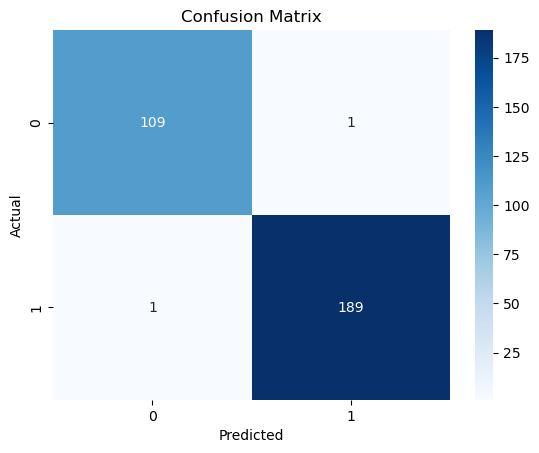

In [105]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop( ['is_genuine'], axis = 1 )
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, 
                                                  random_state = 68 )
## Define algorithm
model = XGBClassifier( **opt_xgb.best_params_, 
                      objective = 'binary:logistic', 
                      random_state = 68 )

## Get time before fitness
start_fit = time.time()

## Fit model
model.fit( x_train, y_train )

## Get time after model fitness
end_fit = time.time()

## predict values for test set
y_test_pred = model.predict( x_test )

## Get prediction time
end_pred = time.time()

## predict values for train set
y_train_pred = model.predict( x_train )

## Check the F1 metrics for train and test sets
f1_xgb = f1_score(y_test, y_test_pred)
print( "F1 score on training set:", f1_score( y_train, y_train_pred) )
print( "F1 score on validation set:", f1_xgb )

# Evaluate precision and recall values
precision_xgb = precision_score( y_test, y_test_pred )
recall_xgb = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_xgb:.3f}" )
print( f"Recall:    {recall_xgb:.3f}" )

## Get and show timings for fitness and prediction
time_fit_xgb = (end_fit - start_fit)
time_pred_xgb = (end_pred - end_fit)
print( f"Model fitness time: {time_fit_xgb:.4f}" )
print( f"Model prediction time: {time_pred_xgb:.4f}" )

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on training and validation sets are both excellent, there is no overfitting.

This model has 0.5% of false negative and 0.5% of false positive. It is exactly the same as the Logistic regression.

The model fitness took 0.11 seconds and prediction time is almost instant.

## Explainable Boosting
Newer models known as glassbox allow classification without the "blackbox" of the regular machine learning. This means that while retaining the excellent classification of prediction potential of machine learning, the content of the algorithm can be vizualized and interpreted by humans. Here we will use the Explainable Boosting Classifier.
This model is robust to overfitting and parameter fitting is long and has a low effect on results. We will not do it.

### Fit model and visualize variable importance

In [ ]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 68)

ebc = ExplainableBoostingClassifier()

## Get time before fitness
start_fit = time.time()
## Fit model
ebc.fit(x_train, y_train)
## Get time after model fitness
end_fit = time.time()
time_fit_ebc = (end_fit - start_fit)

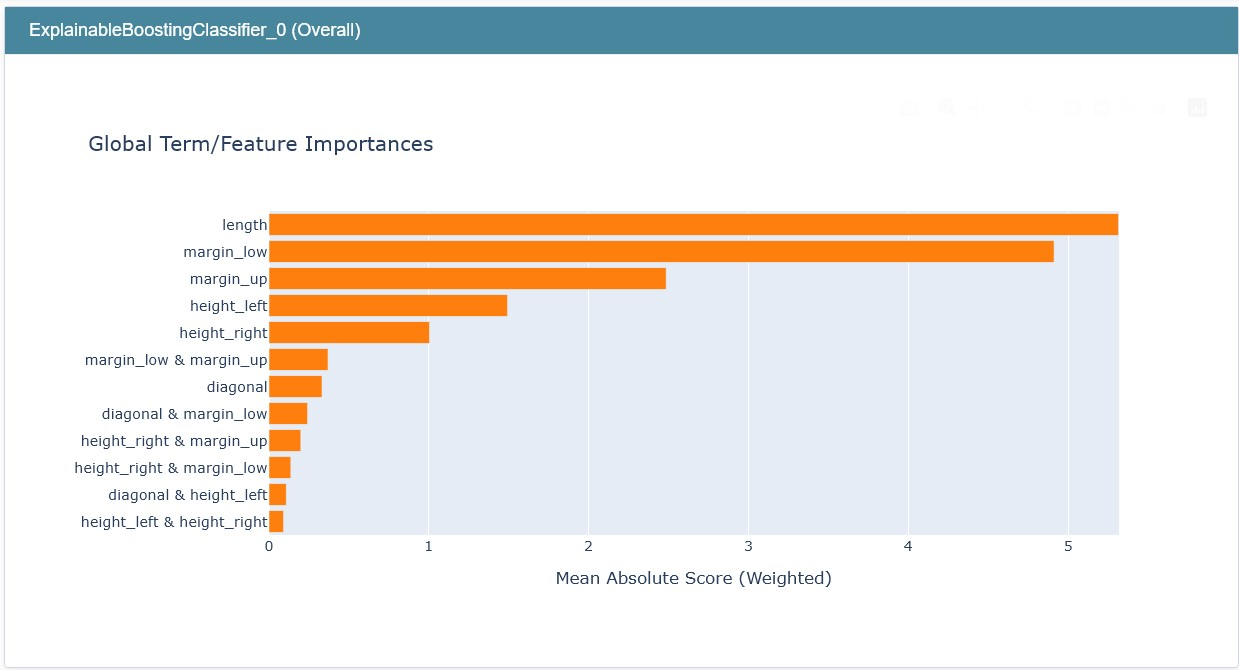

In [6]:
## Show variable importance
ebc_global = ebc.explain_global()

## Run the following only from a notebook
#show(ebc_global, notebook = True)

## Static image of the result
from IPython.display import Image
Image(filename = '../Data/expl_boost_pic.jpg')

As expected, the margin_low and length parameters are by far the most important.

In [5]:
## Predict and visualize each prediction
ebc_local = ebc.explain_local(x_test, y_test)

## Run the following only from a notebook
#show(ebc_local, notebook = True)

### Evaluate model accuracy metrics and fitness

F1 score on training set: 1.0
F1 score on validation set: 0.9921259842519685
Precision: 0.990
Recall:    0.995
Model fitness time: 16.5794
Model prediction time: 0.1002


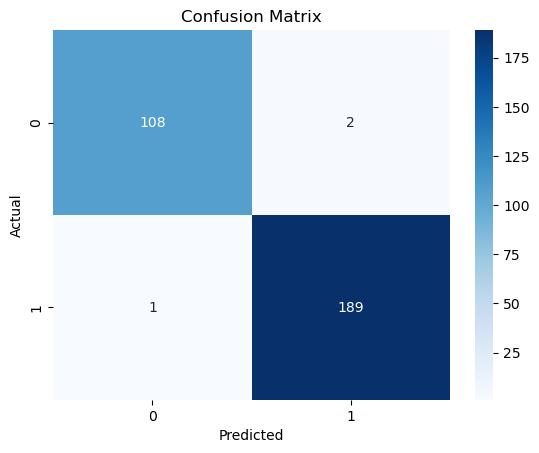

In [106]:

## Get time after model fitness
end_fit = time.time()
## Predict test sample
y_test_pred = ebc.predict(x_test)
## Get prediction time
end_pred = time.time()

## Predict training values
y_train_pred = ebc.predict(x_train)

## Check the F1 metrics for train and test sets
f1_ebc = f1_score(y_test, y_test_pred)
print( "F1 score on training set:", f1_score( y_train, y_train_pred) )
print( "F1 score on validation set:", f1_ebc )

# Evaluate precision and recall values
precision_ebc = precision_score( y_test, y_test_pred )
recall_ebc = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_ebc:.3f}" )
print( f"Recall:    {recall_ebc:.3f}" )


## Get and show timings for fitness and prediction
time_pred_ebc = (end_pred - end_fit)
print( f"Model fitness time: {time_fit_ebc:.4f}" )
print( f"Model prediction time: {time_pred_ebc:.4f}" )

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on training and validation sets are both excellent, there is no overfitting.

This model has 0.5% of false negative and 1% of false positive. It is exactly the same as the Logistic regression, and slightly worse than the other machine learning algorithms tested.

The model fitness took almost 19 seconds to be completed and each prediction took 6ms. It is much slower than all the other algorithms tested until now.

## Gaussian Mixture Model
The Gaussian Mixture model is an unsupervised ML algorithm, which is more flexible than the K-Means algorithm.
The two most important parameter is the number of components.

### Get the best number of clusters

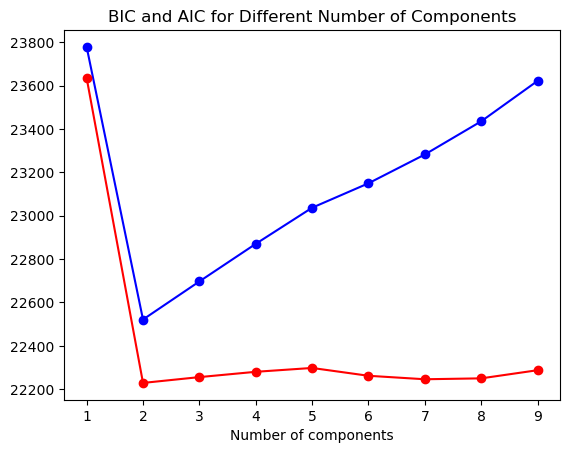

In [91]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Scale the predictors to help the algorithm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## BIC and AIC score storing 
bic_scores = []
aic_scores = []
n_components_range = range(1, 10)

## Get BIC and AIC scores
for n in n_components_range:
    gmm = GaussianMixture(n_components = n, 
                          covariance_type = 'full',
                          random_state = 68)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append( gmm.aic(X_scaled) )    

## Plot BIC scores
plt.plot( n_components_range, bic_scores, marker = 'o', color = 'blue', label = 'BIC')
plt.plot( n_components_range, aic_scores, marker='o', color = 'red', label = 'AIC' )
plt.title("BIC and AIC for Different Number of Components")
plt.xlabel("Number of components")
plt.show()

As expected, the best number of clusters is 2. Ideally they would fit perfectly the genuine and fake notes clusters. We will now check if the predicted clusters correspond the notes classification.

### Evaluate model accuracy and fitness

In [9]:
## Create X and y arrays with dependent and independent variables
X = notes_full.drop(['is_genuine'], axis = 1)
y = notes_full['is_genuine']

## Scale the predictors to help the algorithm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Split the data between training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, 
                                                    random_state = 68)

gmm = GaussianMixture(n_components = 2, 
                      covariance_type = 'full',
                      random_state = 68)

## Get time of fitness start
start_fit = time.time()
## Fit model
gmm.fit( x_train )
## Get time after fitness
end_fit = time.time()
## Predict the cluster of new data
y_pred_test = gmm.predict(x_test)
## Get time after prediction
end_pred = time.time()

y_pred_train = gmm.predict(x_train)

## Calculate timings for the benchmark
time_fit_gmm = (end_fit - start_fit)
time_pred_gmm = (end_pred - end_fit)

The clusters are labelled with numbers. We need to find which cluster number corresponds to which note type. We will do so by pasting the predicted clusters to the is_genuine column values and see what comes.

In [6]:
## Show the value counts of the prediction
print('Value counts in y_pred_test:')
display( pd.Series(y_pred_test).value_counts() )

## Show the values predicted for the genuine notes
print('\nValue counts in y_pred_test for genuine notes only:')
display( pd.Series(y_pred_test[ y_test ]).value_counts() )


Value counts in y_pred_test:


0    191
1    109
Name: count, dtype: int64


Value counts in y_pred_test for genuine notes only:


0    190
Name: count, dtype: int64

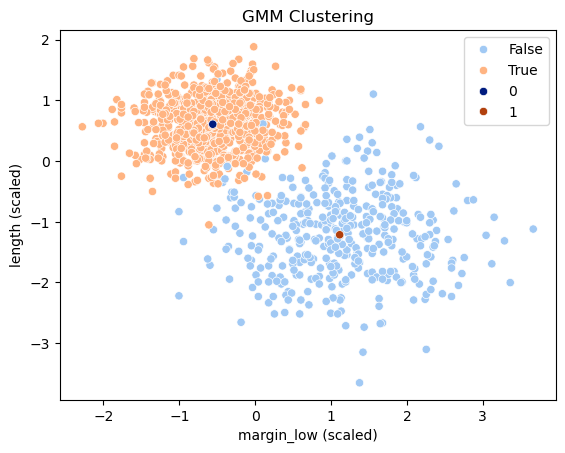

In [7]:
## Get centroids
centroids = gmm.means_

## Plot 
palette = sns.color_palette("deep", n_colors = 2)

sns.scatterplot( x = x_train[:, 3], y = x_train[:, 5],
                hue = y_train, marker = 'o', alpha = 1 ,
               palette = 'pastel')
sns.scatterplot( x = centroids[:, 3], y = centroids[:, 5],
                hue = [0 , 1], palette = 'dark',
                marker = 'o')
plt.title( 'GMM Clustering' )
plt.xlabel( 'margin_low (scaled)' )
plt.ylabel( 'length (scaled)' )
plt.show()

Almost all the genuine notes are predicted as 0, and none of them are predicted as 1. The cluster 0 corresponds to the 'True' value in is_genuine, 1 corresponds to 'False'.

Based on this we can calculate the accuracy of our model as we did for the other algorithms.

F1 score on training set: 0.9932224276032039
F1 score on validation set: 0.9973753280839895
Precision: 0.995
Recall:    1.000
Model fitness time: 0.0120
Model prediction time: 0.0000


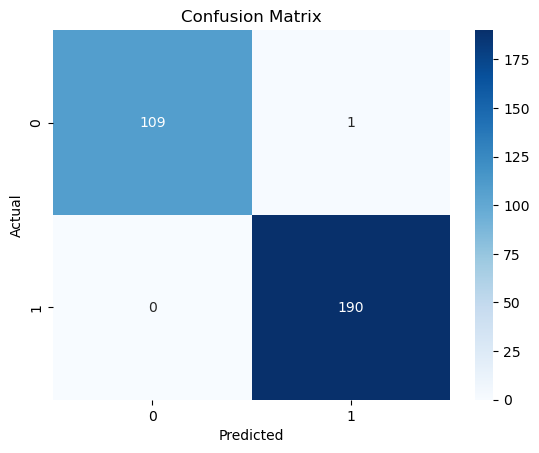

In [12]:
## Turn predictions to corresponding boolean
y_test_pred = ~y_pred_test.astype('bool')
y_train_pred = ~y_pred_train.astype('bool')

## Calculate accuracy metrics
## Check the F1 metrics for train and test sets
f1_gmm = f1_score(y_test, y_test_pred)
print( "F1 score on training set:", f1_score( y_train, y_train_pred) )
print( "F1 score on validation set:",  f1_gmm)

# Evaluate precision and recall values
precision_gmm = precision_score( y_test, y_test_pred )
recall_gmm = recall_score( y_test, y_test_pred )

print( f"Precision: {precision_gmm:.3f}" )
print( f"Recall:    {recall_gmm:.3f}" )

## Get timings
print( f"Model fitness time: {time_fit_gmm:.4f}" )
print( f"Model prediction time: {time_pred_gmm:.4f}" )

## Plot confusion matrix
confusion_matrix_plot( y_test, y_test_pred )

The scores on the training and validation sets are excellent, there is no overfitting.
The accuracy is slightly better than with the other algorithms, as there is only 0.5% of false negative for no false positive.

# Algorithm comparison


We can now compare the speed and accuracy of the different models. To do so we will put side by side the inaccuracy metrics (1-f1, 1-precision, 1-recall) for each model. We will also look at the fitness time, but will not look at the prediction time which is always below our detection limit.

In [68]:
## Create accuracy data frame
acc_df = pd.DataFrame({
    'Algorithm' : ['KNN'] * 3 + ['RF'] * 3 + ['Log_reg'] * 3 + ['XGBoost'] * 3 + ['GMM'] * 3 + ['ExplBoost'] * 3 ,
    'metric' : ['f1', 'precision', 'recall'] * 6,
    'acc_score' : [f1_knn, precision_knn, recall_knn, 
               f1_rfc, precision_rfc, recall_rfc, 
               f1_lgr, precision_lgr, recall_lgr, 
               f1_xgb, precision_xgb, recall_xgb, 
               f1_gmm, precision_gmm, recall_gmm, 
               f1_ebc, precision_ebc, recall_ebc ]
}
)

## Create inaccuracy column 
acc_df['inaccuracy'] = round( (1 - acc_df['acc_score']), 4)

acc_df.head(10)

Algorithm     metric  acc_score  inaccuracy
0       KNN         f1   0.994737      0.0053
1       KNN  precision   0.994737      0.0053
2       KNN     recall   0.994737      0.0053
3        RF         f1   0.994764      0.0052
4        RF  precision   0.989583      0.0104
5        RF     recall   1.000000      0.0000
6   Log_reg         f1   0.994764      0.0052
7   Log_reg  precision   0.989583      0.0104
8   Log_reg     recall   1.000000      0.0000
9   XGBoost         f1   0.994737      0.0053

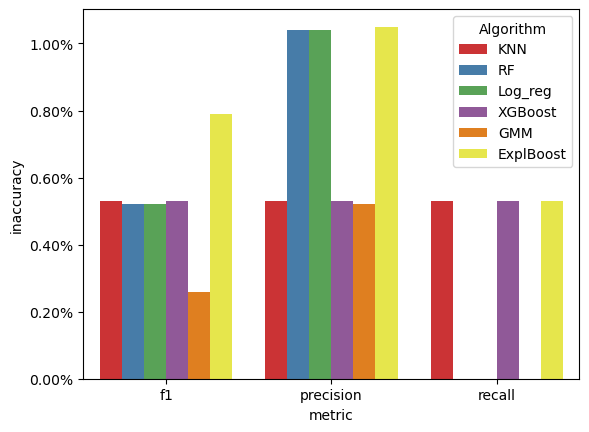

In [69]:
import matplotlib.ticker as mtick
## Plot inaccuracy
inacc_plot = sns.barplot(acc_df,
                        x = 'metric', y = 'inaccuracy',
                        hue = 'Algorithm',
                         palette = 'Set1'
                        )

inacc_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

The Gaussian Mixed Model stands out as the best, with no false negative and low false positive rates.
The Explainable Boost stands out as the worst model with high false positive rate but still some false negatives.

We will not look at the prediction time because it is always below the detection limit except for the Explainable Boosting algorithm.

In [82]:
## Create data frame
fitness_df = pd.DataFrame({
    'Algorithm' : ['KNN'] + ['RF'] + ['Log_reg'] + ['XGBoost'] + ['GMM'] + ['ExplBoost'],
    'fitness time' : [time_fit_knn, time_fit_rfc, time_fit_lgr, time_fit_xgb, time_fit_gmm, time_fit_ebc]}
)

## Add 1 for log scale
fitness_df['fitness time'] = fitness_df['fitness time']

fitness_df

Algorithm  fitness time
0        KNN      0.000000
1         RF      0.174820
2    Log_reg      0.713446
3    XGBoost      0.110307
4        GMM      0.020130
5  ExplBoost     16.579378

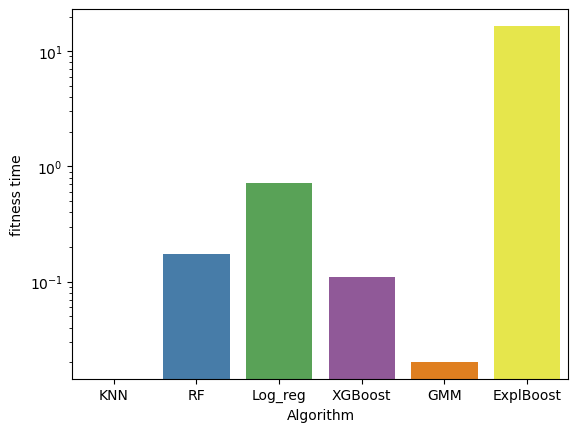

In [86]:
## Plot inaccuracy
fitness_plot = sns.barplot(fitness_df,
                        x = 'Algorithm', y = 'fitness time',
                        hue = 'Algorithm',
                        palette = 'Set1'
                        )

fitness_plot.set_yscale('log')

plt.show()

The KNN and GMM are by far the fastest, but all the models fitting in less than a second could be good. The clearly worse model here is the Explainable boosting algorithm and its 16+ seconds fitness time.

# Model export
We will export our Gaussian Mixture Model for further use, as well as the fitted scaler.

In [111]:
## Export model
joblib.dump(gmm, 'Notes_detection_GMM.pkl')
joblib.dump(scaler, 'Notes_detection_scaler.pkl')

['Notes_detection_scaler.pkl']